In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Station = Base.classes.station
measurement= Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [20]:
# Find the most recent date in the data set.

most_recent_date = session.query(measurement.date).order_by(desc(measurement.date)).first()[0]
print(most_recent_date)




2017-08-23


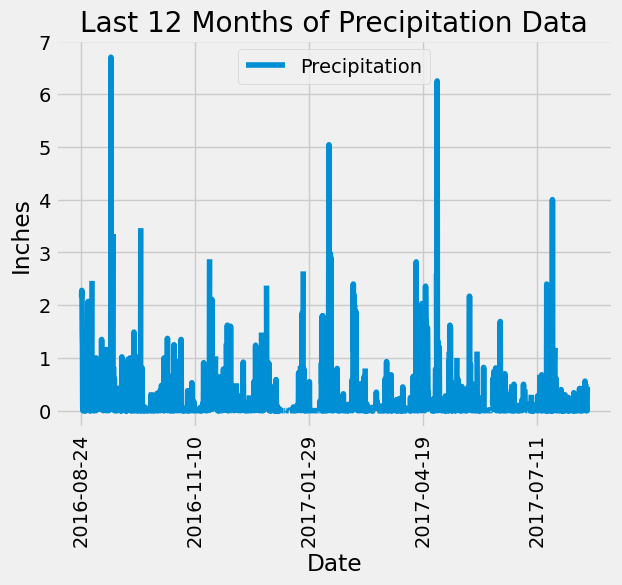

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(func.max(measurement.date)).scalar()
one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', title='Last 12 Months of Precipitation Data')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.show()

In [28]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
summary_statistics

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number of stations in the dataset
stations_total = session.query(measurement).group_by(measurement.station).count()
stations_total

9

In [31]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations_query = session.query(measurement.station, func.count(measurement.station).label('station_count')).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc())
active_stations_results = active_stations_query.all()


for station, count in active_stations_results:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [33]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'
temperature_summary_query = session.query(
    func.min(measurement.tobs).label('min_temperature'),
    func.max(measurement.tobs).label('max_temperature'),
    func.avg(measurement.tobs).label('avg_temperature')
).filter(measurement.station == most_active_station_id)


temperature_summary = temperature_summary_query.first()

print(f"Most Active Station: {most_active_station_id}")
print(f"Lowest Temperature: {temperature_summary.min_temperature}")
print(f"Highest Temperature: {temperature_summary.max_temperature}")
print(f"Average Temperature: {temperature_summary.avg_temperature}")

Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


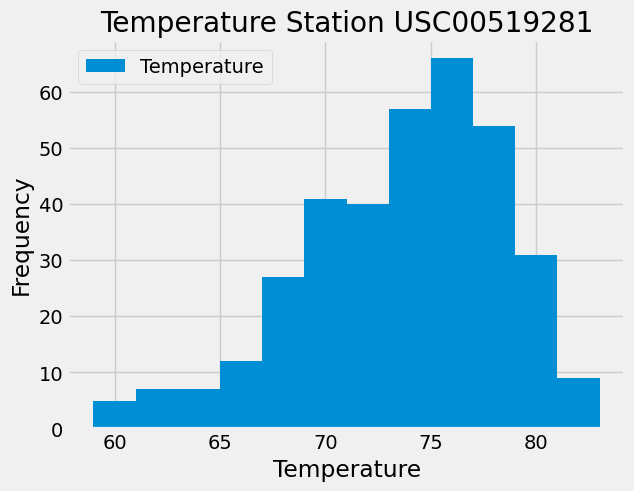

In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date = session.query(func.max(measurement.date)).filter(measurement.station == most_active_station_id).scalar()
one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

temperature_data_query = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == most_active_station_id).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date)

temperature_data_results = temperature_data_query.all()

temperature_df = pd.DataFrame(temperature_data_results, columns=['Date', 'Temperature'])

#Histogram
plt.hist(temperature_df['Temperature'], bins=12, label='Temperature')
plt.title(f'Temperature Station {most_active_station_id}')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()



# Close Session

In [37]:
# Close Session
session.close()